In [44]:
from imp import reload
import utils as ul
import mls as pb
import fw
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

## Data generation

In [2]:
## X: n*p  W: p*m  Y: n*m
np.random.seed(0)
n = 100
m = 100
p = 100
r = 10
nn = 1
X, Y, W = pb.generate(n, m, p, r, nn)

In [3]:
from sklearn.linear_model import MultiTaskLasso
MultiTaskLasso(alpha=.001).fit(X, Y).score(X, Y)

0.99730267956781216

In [4]:
points = ul.mat2point(X,Y)
dataRDD = sc.parallelize(points).mapPartitions(ul.point2mat)
hashedDataRDD = dataRDD.map(ul.hashkey)
modelRDD = hashedDataRDD.mapValues(pb.Model).persist()

## Loss vs. Epoch

In [22]:
T = 30                        # number of iterations of FW
loss = np.zeros((8, T + 1))

In [39]:
# experiement parameter
np.random.seed(0)             
v0 = np.random.randn(m)

LMO = {#0: fw.centralize, 
       #1: fw.avgmix,
       #2: lambda x, t: fw.poweriter(x, t, lambda t: 1, v0),
       #3: lambda x, t: fw.poweriter(x, t, lambda t: 2, v0),
       #4: lambda x, t: fw.poweriter(x, t, lambda t: 1),
       #5: lambda x, t: fw.poweriter(x, t, lambda t: 2),
       6: lambda x, t: fw.poweriter(x, t, fw.loground, v0),
       #7: lambda x, t: fw.poweriter(x, t, fw.loground)
      }

In [40]:
for i, lmo in LMO.items():
    # initialization
    loss[i, 0] = pb.loss(X, Y)
    paramRDD = modelRDD.mapValues(lambda x: pb.Param((x.p, x.m)))
    np.random.seed(0)
    
    # iteration
    for t in range(T):
        paramRDD, _, _, loss[i, t + 1] = fw.iterate(modelRDD, paramRDD, lmo, fw.linearsearch, 1, t)

    loss[i, :] /= loss[i, 0]

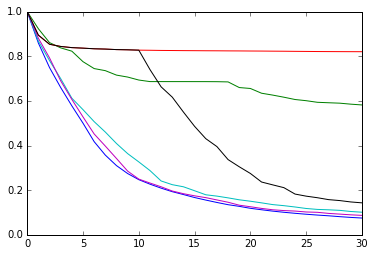

In [41]:
plt.plot(loss.T)

## Loss vs. Time

In [60]:
elapsed = np.zeros((8, T + 1))

In [76]:
# experiement parameter
np.random.seed(0)             
v0 = np.random.randn(m)

LMO = {#0: fw.centralize, 
       #1: fw.avgmix,
       #2: lambda x, t: fw.poweriter(x, t, lambda t: 1, v0),
       #3: lambda x, t: fw.poweriter(x, t, lambda t: 2, v0),
       4: lambda x, t: fw.poweriter(x, t, lambda t: 1),
       #5: lambda x, t: fw.poweriter(x, t, lambda t: 2),
       6: lambda x, t: fw.poweriter(x, t, fw.loground, v0),
       #7: lambda x, t: fw.poweriter(x, t, fw.loground)
      }

In [77]:
for i, lmo in LMO.items():
    # initialization
    paramRDD = modelRDD.mapValues(lambda x: pb.Param((x.p, x.m)))
    np.random.seed(0)
    
    # iteration
    elapsed[i, 0] = time.time()
    for t in range(T):
        paramRDD, _, _, _ = fw.iterate(modelRDD, paramRDD, lmo, fw.linearsearch, 1, t, False)
        elapsed[i, t + 1] = time.time()
        
    elapsed[i, :] -= elapsed[i, 0]

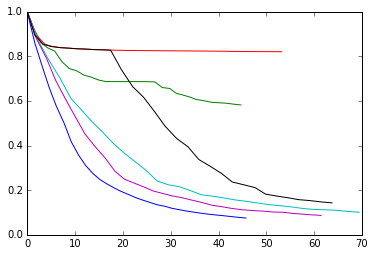

In [78]:
plt.plot(elapsed.T, loss.T)